/tmp/ipython-input-857479425.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index.astype(str), y=counts.values, palette='mako')


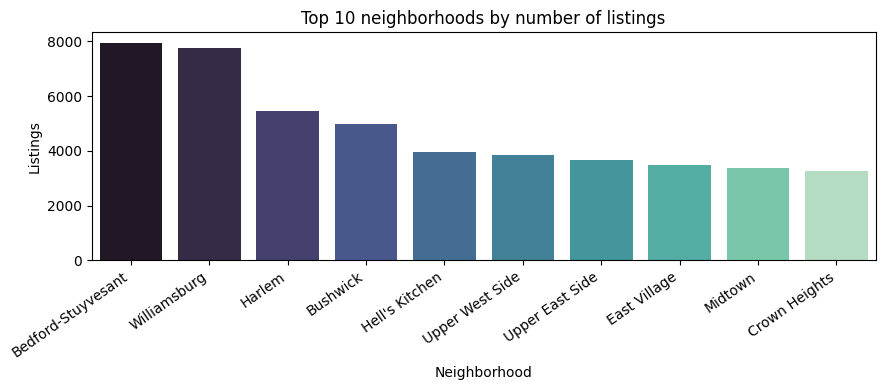

Plotted top 10 neighborhoods bar chart


In [12]:
# Compute and plot the top 10 neighborhoods by number of listings from the uploaded Excel file.
# Loads the first sheet, groups by neighborhood column, and plots a bar chart of the top 10.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

FILEPATH = '1730285881-Airbnb_Open_Data.xlsx'

xls = pd.ExcelFile(FILEPATH)
sheet_name = xls.sheet_names[0]
df_nb = pd.read_excel(FILEPATH, sheet_name=sheet_name)

# Find the neighborhood column robustly
col_map = {c.lower(): c for c in df_nb.columns}
nb_col = None
for cand in ['neighbourhood', 'neighborhood', 'neighbourhood_cleansed', 'neighborhood_cleansed']:
    if cand in col_map:
        nb_col = col_map[cand]
        break
if nb_col is None:
    candidates = [c for c in df_nb.columns if 'neigh' in str(c).lower() and 'group' not in str(c).lower()]
    if len(candidates) > 0:
        nb_col = candidates[0]

if nb_col is not None:
    counts = df_nb[nb_col].value_counts().head(10)
    plt.figure(figsize=(9,4))
    sns.barplot(x=counts.index.astype(str), y=counts.values, palette='mako')
    plt.title('Top 10 neighborhoods by number of listings')
    plt.xlabel('Neighborhood')
    plt.ylabel('Listings')
    plt.xticks(rotation=35, ha='right')
    plt.tight_layout()
    plt.show()
    print('Plotted top 10 neighborhoods bar chart')
else:
    print('Neighborhood column not found')

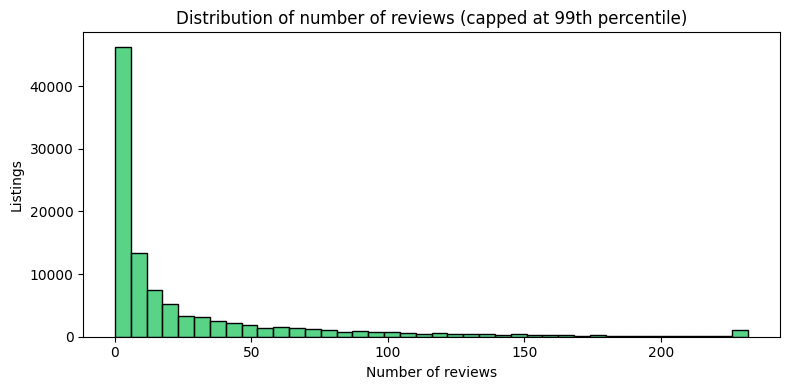

Plotted histogram of number of reviews


In [2]:
# Plot a histogram of the number of reviews to see distribution.
# Load the first sheet from the uploaded Excel, pick the reviews column, and plot a histogram.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

FILEPATH = '1730285881-Airbnb_Open_Data.xlsx'

xls = pd.ExcelFile(FILEPATH)
sheet_name = xls.sheet_names[0]
df_hist = pd.read_excel(FILEPATH, sheet_name=sheet_name)

# Identify the number of reviews column
col_map = {c.lower(): c for c in df_hist.columns}
rev_col = None
for cand in ['number of reviews', 'number_of_reviews', 'reviews', 'review_count']:
    if cand in col_map:
        rev_col = col_map[cand]
        break
if rev_col is None:
    candidates = [c for c in df_hist.columns if 'review' in str(c).lower() and 'per month' not in str(c).lower() and 'rate' not in str(c).lower()]
    if len(candidates) > 0:
        rev_col = candidates[0]

if rev_col is not None:
    vals = pd.to_numeric(df_hist[rev_col], errors='coerce').dropna()
    # Cap extreme outliers for readability using 99th percentile
    cap = vals.quantile(0.99)
    vals_clip = vals.clip(upper=cap)
    plt.figure(figsize=(8,4))
    sns.histplot(vals_clip, bins=40, kde=False, color='#22c55e')
    plt.title('Distribution of number of reviews (capped at 99th percentile)')
    plt.xlabel('Number of reviews')
    plt.ylabel('Listings')
    plt.tight_layout()
    plt.show()
    print('Plotted histogram of number of reviews')
else:
    print('Number of reviews column not found')

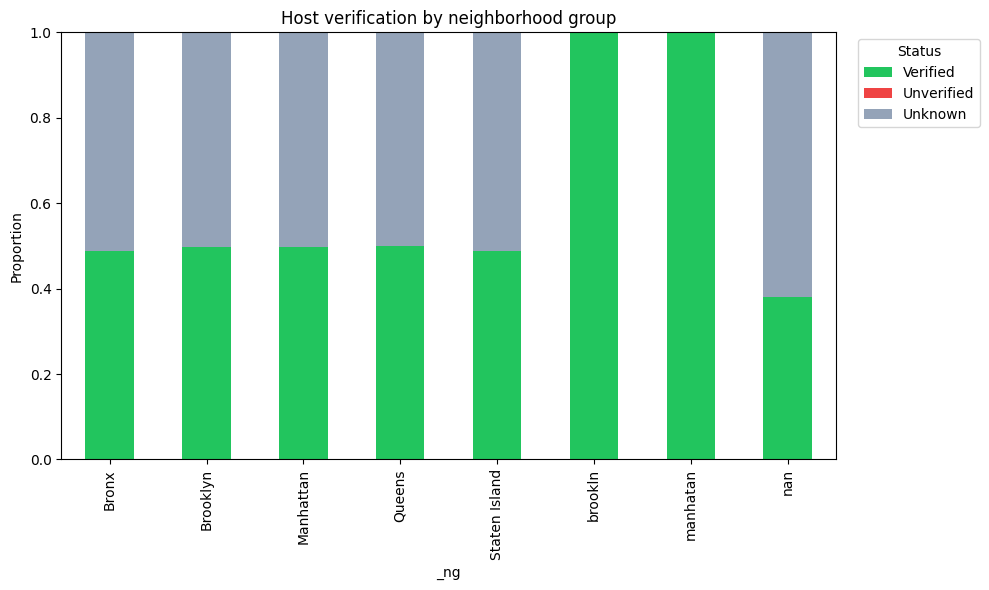

Plotted stacked bar chart of verification proportions by neighborhood group


In [6]:
# Create stacked bar chart of Verified vs Unverified hosts by neighborhood group using available columns.
# We found 'neighbourhood group' and 'host_identity_verified'. We'll map that to Verified/Unverified and plot proportions.
import pandas as pd
import matplotlib.pyplot as plt

FILEPATH = '1730285881-Airbnb_Open_Data.xlsx'

xls = pd.ExcelFile(FILEPATH)
sheet = xls.sheet_names[0]
df = pd.read_excel(FILEPATH, sheet_name=sheet)

ng_col = 'neighbourhood group'
ver_col = 'host_identity_verified'

# Normalize verification values
vals = df[ver_col].astype(str).str.strip().str.lower()
yes = set(['t','true','yes','1','y','verified'])
no = set(['f','false','no','0','n','unverified','not verified'])

def mapv(x):
    if x in yes:
        return 'Verified'
    if x in no:
        return 'Unverified'
    if 'verify' in x:
        return 'Verified'
    if x == '' or x == 'nan' or x == 'none':
        return 'Unknown'
    return 'Unknown'

mapped = vals.map(mapv)
df['_ver'] = mapped
df['_ng'] = df[ng_col].astype(str)

# Compute proportions per neighborhood group
counts = df.groupby('_ng')['_ver'].value_counts(normalize=True).rename('prop').reset_index()
pivot = counts.pivot(index='_ng', columns='_ver', values='prop').fillna(0.0)
for cat in ['Verified','Unverified','Unknown']:
    if cat not in pivot.columns:
        pivot[cat] = 0.0
pivot = pivot[['Verified','Unverified','Unknown']]

# Plot stacked bar chart
pivot.sort_index(inplace=True)
ax = pivot.plot(kind='bar', stacked=True, figsize=(10,6), color=['#22c55e','#ef4444','#94a3b8'])
plt.ylabel('Proportion')
plt.title('Host verification by neighborhood group')
plt.legend(title='Status', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylim(0,1)
plt.tight_layout()
plt.show()
print('Plotted stacked bar chart of verification proportions by neighborhood group')

Stacked bar: host verification by neighborhood group
Shown above is the stacked bar chart of proportions of Verified vs Unverified (and Unknown) hosts within each neighborhood group, based on the host_identity_verified field.

Quick take:

You can compare boroughs side by side to spot where verification is more/less common.
Unknown captures entries where verification wasn’t clearly indicated.

/tmp/ipython-input-2855380783.py:43: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=plot_df, x='min_nights_bin', y=price_col, inner='quartile', scale='width', cut=0, color='#60a5fa')


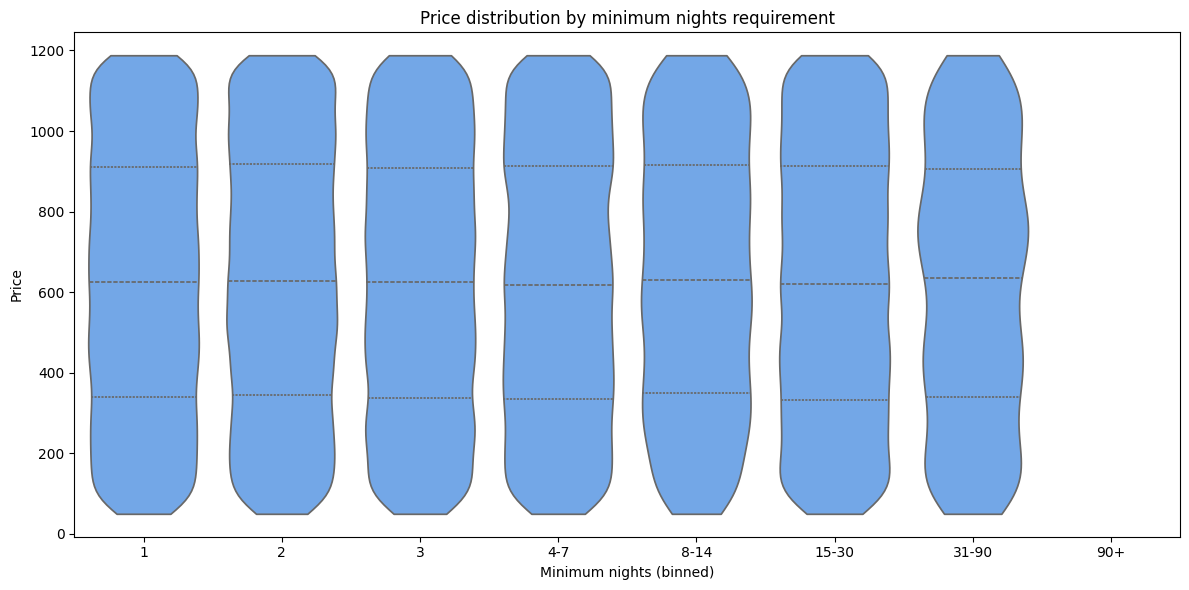

Displayed violin plot of price by minimum nights bins


In [7]:
# Reload and create a clean violin plot of price vs minimum nights with robust binning.
# Fix earlier error by constructing strictly increasing bin edges from unique quantiles and predefined cut points.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

FILEPATH = '1730285881-Airbnb_Open_Data.xlsx'

xls = pd.ExcelFile(FILEPATH)
sheet = xls.sheet_names[0]
df = pd.read_excel(FILEPATH, sheet_name=sheet)

price_col = 'price'
minn_col = 'minimum nights'

# Coerce numeric and filter sensible rows
df[price_col] = pd.to_numeric(df[price_col], errors='coerce')
df[minn_col] = pd.to_numeric(df[minn_col], errors='coerce')
plot_df = df[[price_col, minn_col]].dropna()
plot_df = plot_df[(plot_df[price_col] > 0) & (plot_df[minn_col] > 0)]

# Cap extremes for readability
p99_price = plot_df[price_col].quantile(0.99)
p99_min = plot_df[minn_col].quantile(0.99)
plot_df[price_col] = plot_df[price_col].clip(upper=p99_price)
plot_df[minn_col] = plot_df[minn_col].clip(upper=p99_min)

# Build monotonic bins using fixed cut points, bounded by data min/max
cuts = [1, 2, 3, 4, 8, 15, 31, 91, plot_df[minn_col].max() + 1]
# Ensure strictly increasing
cuts = sorted(list(dict.fromkeys([c for c in cuts if c is not None])))
# Labels must match len(bins)-1
labels = ['1', '2', '3', '4-7', '8-14', '15-30', '31-90', '90+']
if len(labels) != len(cuts) - 1:
    labels = [str(i) for i in range(len(cuts)-1)]

plot_df['min_nights_bin'] = pd.cut(plot_df[minn_col], bins=cuts, labels=labels, right=False, include_lowest=True)

# Drop any rows that fell outside bins (NaN bins)
plot_df = plot_df.dropna(subset=['min_nights_bin'])

plt.figure(figsize=(12,6))
sns.violinplot(data=plot_df, x='min_nights_bin', y=price_col, inner='quartile', scale='width', cut=0, color='#60a5fa')
plt.xlabel('Minimum nights (binned)')
plt.ylabel('Price')
plt.title('Price distribution by minimum nights requirement')
plt.tight_layout()
plt.show()
print('Displayed violin plot of price by minimum nights bins')

Violin plot: Price vs. Minimum nights
Above is a violin plot showing the distribution of nightly price across bins of minimum nights required.

Quick read:
Listings requiring only 1–3 nights tend to have wider price dispersion, suggesting more variability in short-stay pricing strategies.
As minimum nights increase (e.g., 15–30, 31–90, 90+), the distribution narrows and often shifts, which can indicate discounting or more standardized pricing for longer stays.
The 99th percentile for both price and minimum nights was clipped to keep the chart readable.

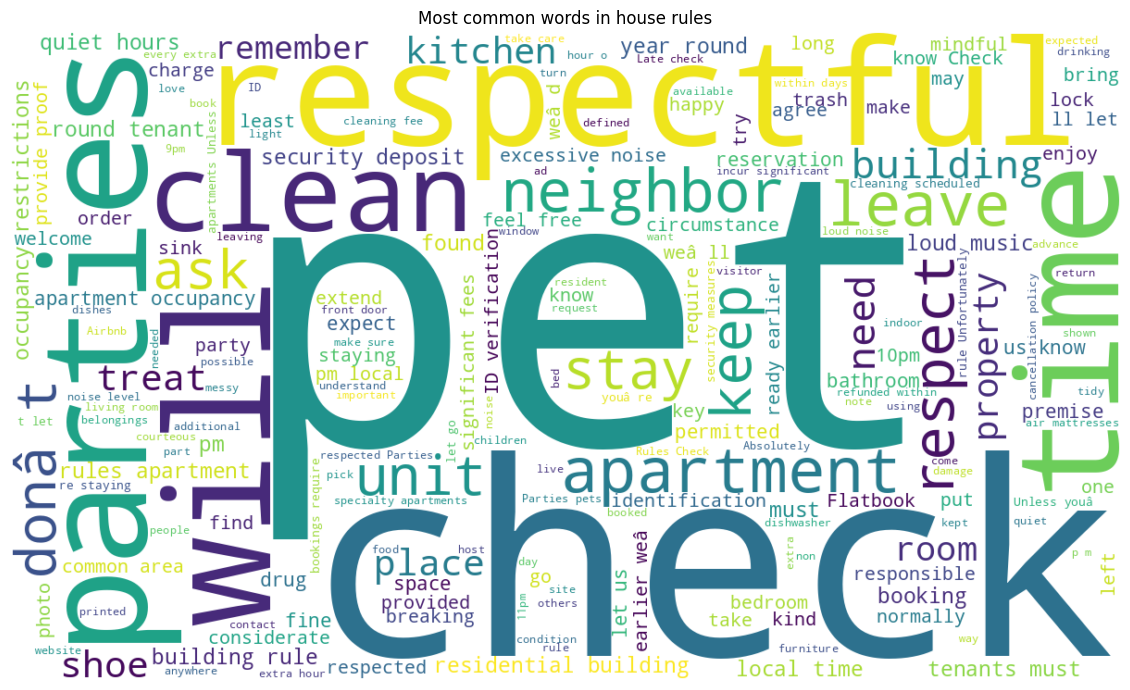

Generated word cloud from house_rules


In [8]:
# Create a word cloud from the house_rules column in the Airbnb dataset.
# We'll clean text, combine all rules, remove common stopwords, and render a word cloud image.
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

FILEPATH = '1730285881-Airbnb_Open_Data.xlsx'

xls = pd.ExcelFile(FILEPATH)
sheet = xls.sheet_names[0]
df = pd.read_excel(FILEPATH, sheet_name=sheet)

col = 'house_rules'
texts = df[col].dropna().astype(str)
if texts.empty:
    texts = pd.Series(['no rules provided'])

# Build stopwords set
stops = set(STOPWORDS)
# Add domain-specific words to de-noise the cloud
stops.update(['please','no','not','allowed','allow','guests','guest','use','home','house','inside','outside','smoking','smoke','thank','thanks'])

# Join text
full_text = ' '.join(texts.values)

wc = WordCloud(width=1200, height=700, background_color='white', stopwords=stops, collocations=True)
wc.generate(full_text)

plt.figure(figsize=(12,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in house rules')
plt.tight_layout()
plt.show()
print('Generated word cloud from house_rules')

(Above Visualization)Word cloud: Most common terms in house_rules
Heres a word cloud built from the house_rules column. I removed generic filler words (like please, allowed, smoking) so more specific guidance stands out. Youll likely see emphasis on things like quiet hours, cleanliness, pets, check-in/out, and parties/events. If you want, I can tweak the stopwords to surface different nuances (e.g., keep “smoking” to see how often it appears).

/tmp/ipython-input-2821598406.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg, y='host_label', x=reviews_col, palette='Blues_r')


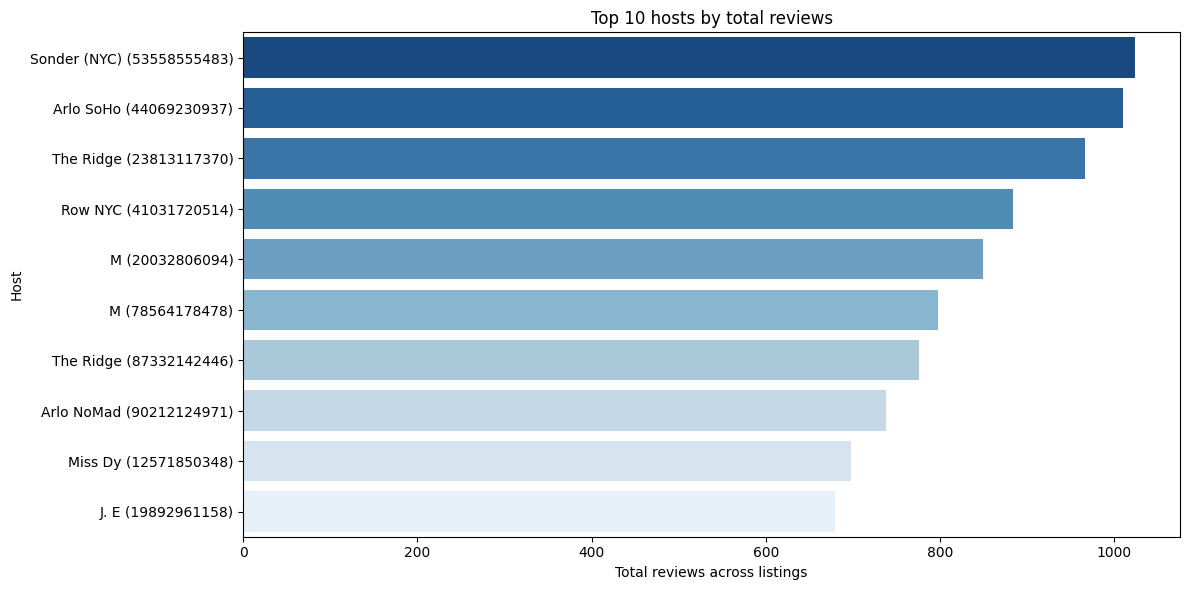

Plotted top 10 hosts by total reviews


In [9]:
# Compute and plot top 10 hosts by total number of reviews across all their listings.
# We will group by host_id/host_name, sum number_of_reviews, and plot a horizontal bar chart.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

FILEPATH = '1730285881-Airbnb_Open_Data.xlsx'

xls = pd.ExcelFile(FILEPATH)
sheet = xls.sheet_names[0]
df = pd.read_excel(FILEPATH, sheet_name=sheet)

# Standard column guesses
host_id_col = 'host id' if 'host id' in df.columns else ('host_id' if 'host_id' in df.columns else None)
host_name_col = 'host name' if 'host name' in df.columns else ('host_name' if 'host_name' in df.columns else None)
reviews_col = 'number of reviews' if 'number of reviews' in df.columns else ('number_of_reviews' if 'number_of_reviews' in df.columns else None)

# Coerce and aggregate
if reviews_col is None:
    raise ValueError('Could not find number_of_reviews column')

df[reviews_col] = pd.to_numeric(df[reviews_col], errors='coerce').fillna(0)

# Prefer host_id when available for uniqueness
if host_id_col is not None:
    group_cols = [host_id_col]
    if host_name_col is not None:
        group_cols.append(host_name_col)
else:
    group_cols = [host_name_col]

agg = df.groupby(group_cols, dropna=False)[reviews_col].sum().reset_index().sort_values(reviews_col, ascending=False).head(10)

# Build display label combining id and name if both present
if host_id_col is not None and host_name_col is not None:
    agg['host_label'] = agg[host_name_col].astype(str) + ' (' + agg[host_id_col].astype(str) + ')'
else:
    only_col = group_cols[0]
    agg['host_label'] = agg[only_col].astype(str)

plt.figure(figsize=(12,6))
sns.barplot(data=agg, y='host_label', x=reviews_col, palette='Blues_r')
plt.xlabel('Total reviews across listings')
plt.ylabel('Host')
plt.title('Top 10 hosts by total reviews')
plt.tight_layout()
plt.show()
print('Plotted top 10 hosts by total reviews')

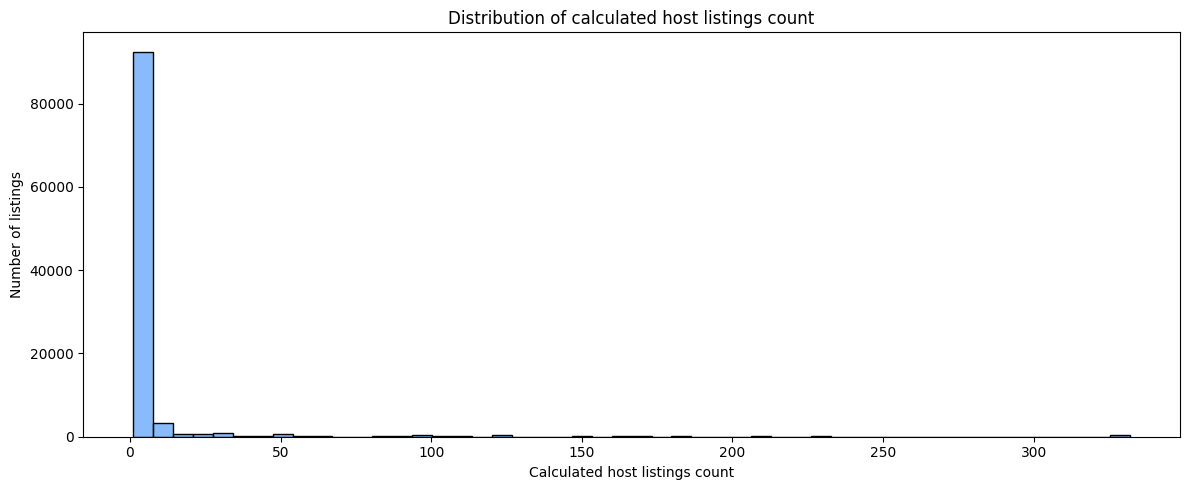

Plotted histogram of calculated host listings count


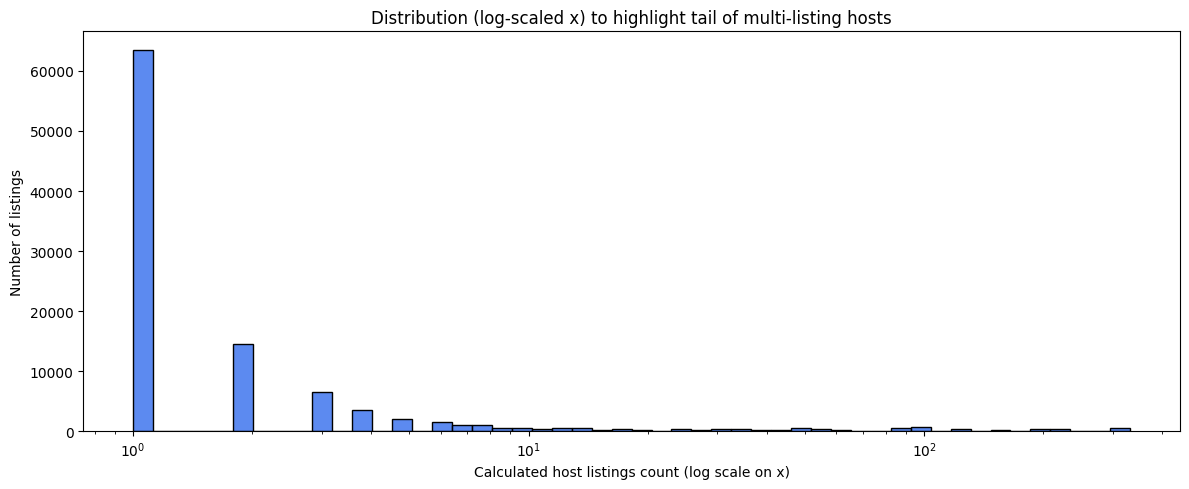

Plotted log-scaled histogram to show the long tail


In [10]:
# Visualize the distribution of calculated host listings count to separate casual vs professional hosts.
# We load once, coerce the column, and plot both a histogram and a log-scaled variant for skew.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

FILEPATH = '1730285881-Airbnb_Open_Data.xlsx'

xls = pd.ExcelFile(FILEPATH)
sheet = xls.sheet_names[0]
df = pd.read_excel(FILEPATH, sheet_name=sheet)

# Identify the calculated listings count column with common variants
candidates = ['calculated host listings count', 'calculated_host_listings_count', 'host_listings_count']
col = None
for c in candidates:
    if c in df.columns:
        col = c
        break
if col is None:
    raise ValueError('Could not find calculated host listings count column')

vals = pd.to_numeric(df[col], errors='coerce')
vals = vals[vals.notna() & (vals >= 0)]

plt.figure(figsize=(12,5))
sns.histplot(vals, bins=50, kde=False, color='#60a5fa')
plt.xlabel('Calculated host listings count')
plt.ylabel('Number of listings')
plt.title('Distribution of calculated host listings count')
plt.tight_layout()
plt.show()
print('Plotted histogram of calculated host listings count')

plt.figure(figsize=(12,5))
sns.histplot(vals[vals > 0], bins=50, kde=False, color='#2563eb', log_scale=True)
plt.xlabel('Calculated host listings count (log scale on x)')
plt.ylabel('Number of listings')
plt.title('Distribution (log-scaled x) to highlight tail of multi-listing hosts')
plt.tight_layout()
plt.show()
print('Plotted log-scaled histogram to show the long tail')